# Setting

## Library

In [1]:
# 데이터 다루기
import pandas as pd
import numpy as np
from itertools import combinations

# 전처리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, TruncatedSVD, FastICA
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

# 모델링
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 기타
import os
import random

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

## Fixed Random Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# Load Data Set

## Read CSV

In [5]:
train = pd.read_csv('./train.csv')
val = pd.read_csv('./val.csv')
test = pd.read_csv('./test.csv')

In [6]:
val['Class'].value_counts()

0    28432
1       30
Name: Class, dtype: int64

# Preprocessing

## Feature Selection

In [7]:
X_train = train.drop(columns=['ID']) 

X_val = val.drop(columns=['ID', 'Class']) 
y_val = val['Class']

X_test = test.drop(columns=['ID'])

In [8]:
X_train = X_train[['V3', 'V4', 'V9', 'V10', 'V11',
                   'V12', 'V14', 'V16', 'V17', 'V18']]

X_val = X_val[['V3', 'V4', 'V9', 'V10', 'V11',
               'V12', 'V14', 'V16', 'V17', 'V18']]

X_test = X_test[['V3', 'V4', 'V9', 'V10', 'V11',
                 'V12', 'V14', 'V16', 'V17', 'V18']]

In [9]:
len(X_train.columns)

10

## Scaling

In [10]:
#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler(quantile_range=(25.0, 75.0))

scaled_train = scaler.fit_transform(X_train)
scaled_val = scaler.transform(X_val)
scaled_test = scaler.transform(X_test)

scaled_train = pd.DataFrame(scaled_train)
scaled_val = pd.DataFrame(scaled_val)
scaled_test = pd.DataFrame(scaled_test)

In [11]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler(quantile_range=(45.0, 55.0))

scaled_train = scaler.fit_transform(scaled_train)
scaled_val = scaler.transform(scaled_val)
scaled_test = scaler.transform(scaled_test)

scaled_train = pd.DataFrame(scaled_train)
scaled_val = pd.DataFrame(scaled_val)
scaled_test = pd.DataFrame(scaled_test)

## 파생 변수

In [12]:
main_columns = list(scaled_train.columns)

com_main = list(combinations(main_columns, 5))
print(len(com_main))

252


In [13]:
for com in com_main:

  x = com[0]
  y = com[1]
  z = com[2]
  w = com[3]
  v = com[-1]

  scaled_train[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_train[x] + \
                                               scaled_train[y] + \
                                               scaled_train[z] + \
                                               scaled_train[w] + \
                                               scaled_train[v]) / 5
    
  scaled_val[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_val[x] + \
                                             scaled_val[y] + \
                                             scaled_val[z] + \
                                             scaled_val[w] + \
                                             scaled_val[v]) / 5

  scaled_test[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_test[x] + \
                                              scaled_test[y] + \
                                              scaled_test[z] + \
                                              scaled_test[w] + \
                                              scaled_test[v]) / 5

In [14]:
print(len(scaled_train.columns))
n_components = len(scaled_train.columns)

262


## 차원 축소

In [32]:
def dimension_isolate_forest(train, val, test, random_state):

  dimesion_reducer = SparsePCA(n_components=128,
                             alpha=0.001,
                             random_state=random_state)

  PCA_train = dimesion_reducer.fit_transform(train)
  PCA_val = dimesion_reducer.transform(val)
  PCA_test = dimesion_reducer.transform(test)

  PCA_train = pd.DataFrame(PCA_train) 
  PCA_val = pd.DataFrame(PCA_val)
  PCA_test = pd.DataFrame(PCA_test)

  dimesion_reducer = SparseRandomProjection(n_components=128,
                                          eps=0.1,
                                          random_state=42)

  SRP_train = dimesion_reducer.fit_transform(train)
  SRP_val = dimesion_reducer.transform(val)
  SRP_test = dimesion_reducer.transform(test)

  SRP_train = pd.DataFrame(SRP_train)
  SRP_val = pd.DataFrame(SRP_val)
  SRP_test = pd.DataFrame(SRP_test)
  
  dimesion_reducer = FastICA(n_components=128,
                           algorithm='parallel',
                           whiten=True,
                           max_iter=150,
                           random_state=42)

  ICA_train = dimesion_reducer.fit_transform(train)
  ICA_val = dimesion_reducer.transform(val)
  ICA_test = dimesion_reducer.transform(test)

  ICA_train = pd.DataFrame(ICA_train)
  ICA_val = pd.DataFrame(ICA_val)
  ICA_test = pd.DataFrame(ICA_test)
    
  preprocessed_train = pd.concat([PCA_train,
                                  SRP_train,
                                  ICA_train],
                                 axis=1)

  preprocessed_val = pd.concat([PCA_val,
                                SRP_val,
                                ICA_val],
                               axis=1)
    
  preprocessed_test = pd.concat([PCA_test,
                                 SRP_test,
                                 ICA_test],
                                axis=1)

  preprocessed_train.columns = [i for i in range(len(preprocessed_train.columns))]
  preprocessed_val.columns = [i for i in range(len(preprocessed_val.columns))]
  preprocessed_test.columns = [i for i in range(len(preprocessed_test.columns))]
    

  return preprocessed_train, preprocessed_val, preprocessed_test

# Modeling

In [33]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [34]:
result_val = np.zeros(val.shape[0])
result_test = np.zeros(test.shape[0])

for rs in range(10):

  reduced_train, reduced_val, reduced_test = dimension_isolate_forest(scaled_train,
                                                                      scaled_val,
                                                                      scaled_test,
                                                                      rs)
  
  model = IsolationForest(n_estimators=100,
                          max_samples=0.80,
                          max_features=0.4,
                          contamination=30/28432,
                          random_state=rs,
                          verbose=0,
                          n_jobs=-1)
  
  model.fit(reduced_train)

  pred_val = model.predict(reduced_val) # model prediction
  pred_val = get_pred_label(pred_val)

  result_val += pred_val


  pred_test = model.predict(reduced_test) # model prediction
  pred_test = get_pred_label(pred_test)

  result_test += pred_test

  val_score = f1_score(y_val, pred_val, average='macro')

  print(f'"{rs}" Marco F1 Score : {val_score}')

"0" Marco F1 Score : 0.8460131793934016
"1" Marco F1 Score : 0.8331750776625051
"2" Marco F1 Score : 0.8331750776625051
"3" Marco F1 Score : 0.8394731804484362
"4" Marco F1 Score : 0.8394731804484362
"5" Marco F1 Score : 0.8460131793934016
"6" Marco F1 Score : 0.8460131793934016
"7" Marco F1 Score : 0.8528093037014359
"8" Marco F1 Score : 0.8460131793934016
"9" Marco F1 Score : 0.8331750776625051


## Evalution

In [35]:
def check(result, ts, val):

  pred_result = []

  for i in result:

    if i >= ts:

      i = 1

    else:

      i = 0

    pred_result.append(i)

  if val == True:

    val_score = f1_score(y_val, pred_result, average='macro')
    recall = recall_score(y_val, pred_result)
    precision = precision_score(y_val, pred_result)

    print(f'Marco F1 Score : {val_score}\n')
    print(f'Recall : {recall}\n')
    print(f'Precision : {precision}\n')

    print(classification_report(y_val, pred_result))

  return pred_result

In [54]:
pred_val = check(result_val, 9, val=True)

Marco F1 Score : 0.8598769209128951

Recall : 0.6

Precision : 0.9

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.90      0.60      0.72        30

    accuracy                           1.00     28462
   macro avg       0.95      0.80      0.86     28462
weighted avg       1.00      1.00      1.00     28462



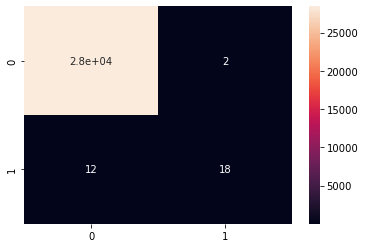

In [55]:
cf_matrix = confusion_matrix(y_val, pred_val)
sns.heatmap(cf_matrix, annot=True)
plt.show()

## Inference

In [56]:
pred_test = check(result_test, 9, val=False)

# Submission

In [57]:
submit = pd.read_csv('./sample_submission.csv')

In [58]:
submit['Class'] = pred_test
submit.head()

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0


In [59]:
submit.to_csv('./submission_22.csv', index=False)